# $$Model\ Tuning$$
---
Experimenting on model hyperparameter tuning for catboost-based regressor

ps : Trained on google colab (laptop not enough resource)

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 69.2 MB 4.5 kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

# Math
import numpy as np
import scipy as sp
import pandas as pd
from numpy import log10, log


# Visualization
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn import metrics

from catboost import CatBoostRegressor, Pool

In [ ]:
# Progress apply for pandas
tqdm.pandas()

plt.style.use('default')

# === Color pallete ===
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0),  # Yellow
    (255, 255, 255), # White
    (0, 0, 0), # Black
]

light_palette = np.array(raw_light_palette)/255

# Inline matplotlib
%matplotlib inline

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

In [ ]:
# Saving model 
def save_model(model, name="model"):
    dir = "gdrive/MyDrive/blibli/"
    pickle.dump(model, open(f"{dir}/bin/{name}", "wb"))
    
# Load Model
def load_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

In [ ]:
def evaluate_model(true, predicted):  
    rmsle = metrics.mean_squared_log_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    print('RMSLE:',rmsle)
    print('RMSE:', rmse)
    print("R2:", r2)
    print('__________________________________')
    return rmsle, rmse, r2 

In [ ]:
# === Color Setup === 
baseline_color = '#F36E8E'
custom_color = '#1ABDE9'
tuned_color = light_palette[10]

## $Data\ Preparation$

**Data Loading**

In [ ]:
# === Load data ===
## EDIT THIS CODE
# =====================
dir = "gdrive/MyDrive/blibli/"
filename = f"{dir}/data/processed/dataset-supervised-processed.pkl"
# =====================

target = "wd_actual_delivery_interval"

df = pd.read_pickle(filename)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

**Feature Preparation**

In [ ]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    df[col] = df[col].astype(int)

100%|██████████| 7/7 [00:00<00:00, 284.31it/s]


**Data Splitting**
- Train size : 80%
- Val size : 20%

In [ ]:
target = "wd_actual_delivery_interval"
X = df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

In [ ]:
rmsle_score = []
rmse_score = []
r2_score = []

## $ Modelling\ Implementation$
---
**Technique Used:**
- Custom loss function -> asymetric mse
- Custom metric func -> RMSLE (custom made)
- Using best model
- Early stopping
- Snapshot save
- Feature Importance
- Saving model

In [ ]:
# === Normal Implementation (No Tuning / Baseline) ===
import pickle
model_file = f"{dir}/bin/catboost-regressor"
baseline_model = load_model(model_file)

**Custom Loss Function**

In [ ]:
class AsymetricMSEObjective(object):
    """
    Penalize 10 time more for late than not late
    """
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        residual = (targets - approxes)
        der1_all = np.where(residual < 0, -2.0 * 10.0 * residual, -2.0 * residual)
        der2_all = np.where(residual < 0, 2.0 * 10.0, 2.0)
        for index in range(len(targets)):
            der1 = der1_all[index]
            der2 = der2_all[index]
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            result.append((der1, der2))
        return result

**Custom Metric Function**

In [ ]:
class RMSLEMetric(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return False

    def evaluate(self, approxes, target, weight):     
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        
        approx = approxes[0]
        
        error_sum = 0.0
        weight_sum = 0.0
        
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((log(max(0,approx[i]) + 1) - log(target[i] + 1)) ** 2)

        return error_sum, weight_sum
        
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return np.sqrt(error / (weight + 1e-38))

In [105]:
from catboost.metrics import RMSE
# == Custom implementation (with custom loss func & metric) ==
param = {
    'eval_metric': RMSLEMetric(),
    'loss_function' : AsymetricMSEObjective(),
    'learning_rate' : 0.025,
    'use_best_model': True,
    'verbose': 20,
    'iterations' : 5000, 
    'random_state' : 123,
    'early_stopping_rounds' : 50,
    'cat_features' : cat_num_features + cat_str_features
}
    
custom_model = CatBoostRegressor(**param)

**Training**

In [106]:
custom_model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test),
    use_best_model=True
)

0:	learn: 2.1322425	test: 2.1420369	best: 2.1420369 (0)	total: 1.22s	remaining: 1h 41m 36s
20:	learn: 0.8933816	test: 0.9010138	best: 0.9010138 (20)	total: 4.74s	remaining: 18m 43s
40:	learn: 0.6866445	test: 0.6934430	best: 0.6934430 (40)	total: 7.97s	remaining: 16m 3s
60:	learn: 0.6140278	test: 0.6201727	best: 0.6201727 (60)	total: 11.4s	remaining: 15m 20s
80:	learn: 0.5786814	test: 0.5844482	best: 0.5844482 (80)	total: 14.8s	remaining: 15m
100:	learn: 0.5598952	test: 0.5656199	best: 0.5656199 (100)	total: 18.2s	remaining: 14m 44s
120:	learn: 0.5485105	test: 0.5542505	best: 0.5542505 (120)	total: 21.7s	remaining: 14m 33s
140:	learn: 0.5406782	test: 0.5464036	best: 0.5464036 (140)	total: 25s	remaining: 14m 21s
160:	learn: 0.5355098	test: 0.5413548	best: 0.5413548 (160)	total: 28.5s	remaining: 14m 15s
180:	learn: 0.5315007	test: 0.5374898	best: 0.5374898 (180)	total: 31.8s	remaining: 14m 7s
200:	learn: 0.5286451	test: 0.5347459	best: 0.5347459 (200)	total: 35.3s	remaining: 14m 2s
220:	l

**Saving Model**

In [109]:
# === Saving Script ===
save_model(custom_model, 'catboost-regressor-custom')

**Applying Result**

In [107]:
baseline_pred = baseline_model.predict(X_test)
baseline_pred = np.where(baseline_pred < 0, 0, baseline_pred)
rmsle, rmse, r2 = evaluate_model(y_test, baseline_pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

RMSLE: 0.17876376434236232
RMSE: 4.664363989171438
R2: 0.40297540507921314
__________________________________


In [108]:
pred = custom_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

RMSLE: 0.2577473482941465
RMSE: 6.023162075241747
R2: 0.004465180603994479
__________________________________


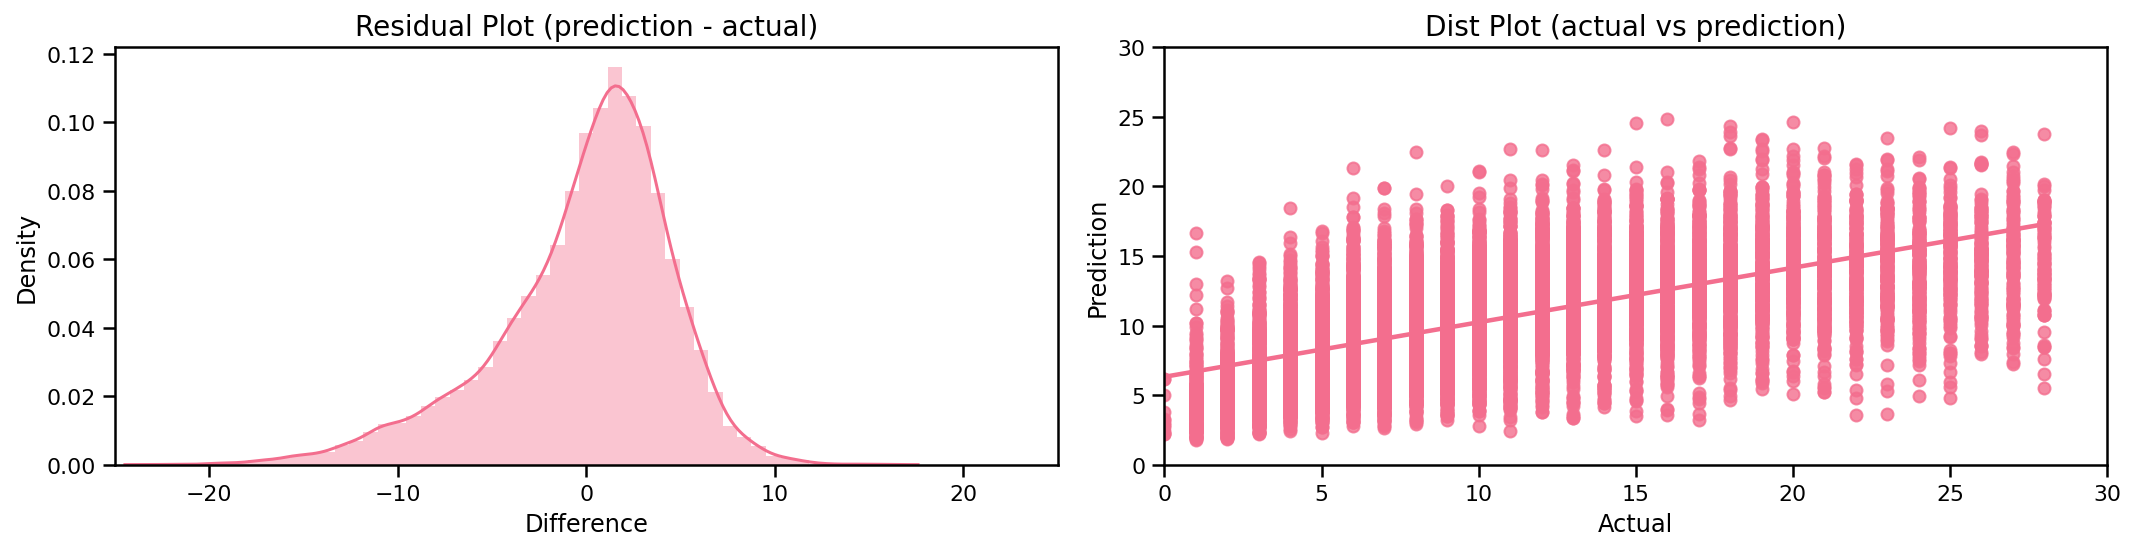

In [110]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : baseline_pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color = baseline_color)
a.set_xlabel("Difference",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color= baseline_color)
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()


plt.tight_layout()
plt.show()

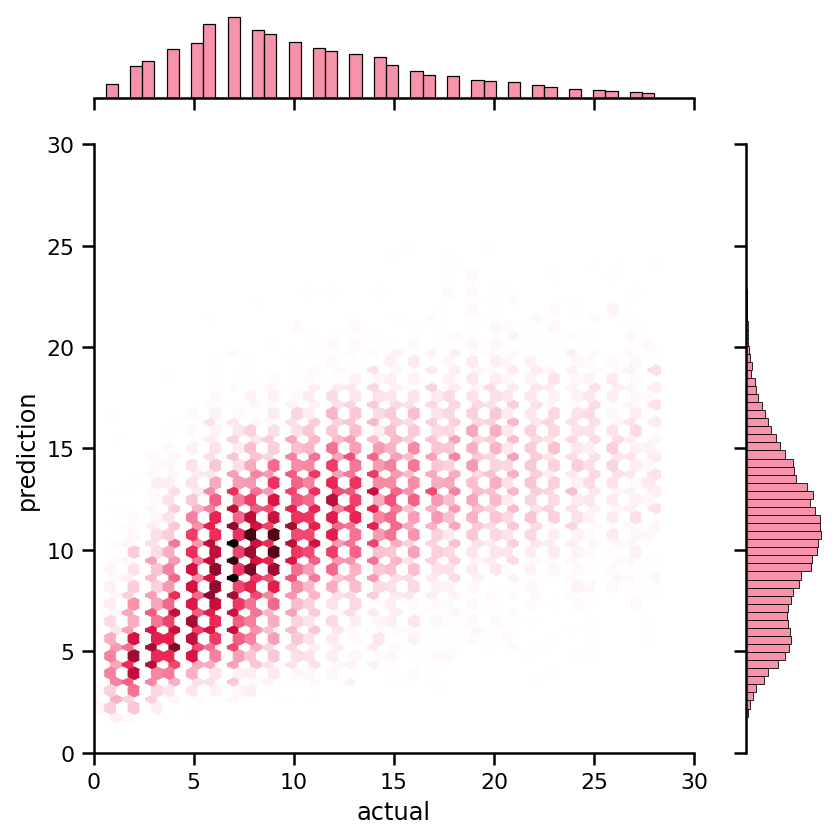

In [111]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : baseline_pred
})

g = sns.jointplot('actual', 'prediction', 
                  data=score_df,kind='hex', 
                  color=baseline_color, xlim=(0,30), ylim=(0,30))
plt.tight_layout()
plt.show()

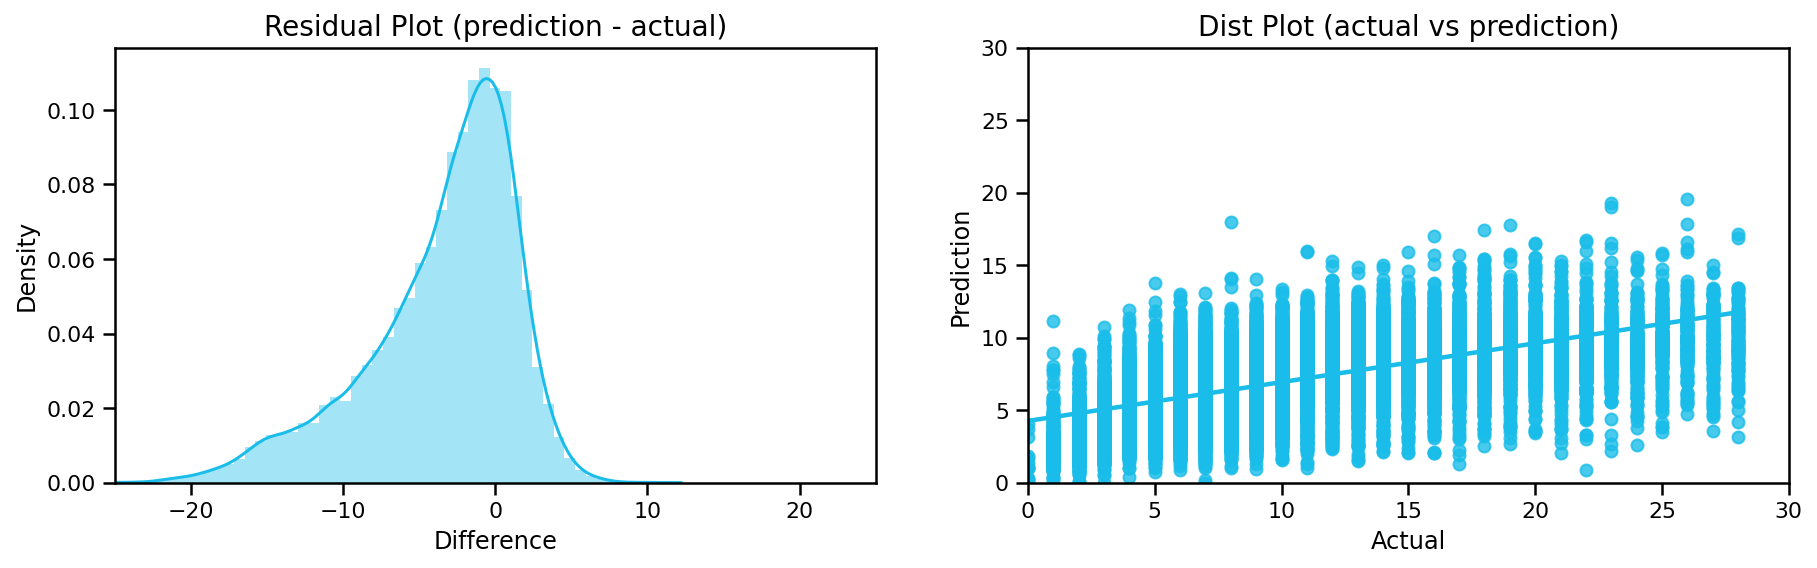

In [112]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color=custom_color)
a.set_xlabel("Difference",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color=custom_color)
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()

plt.show()

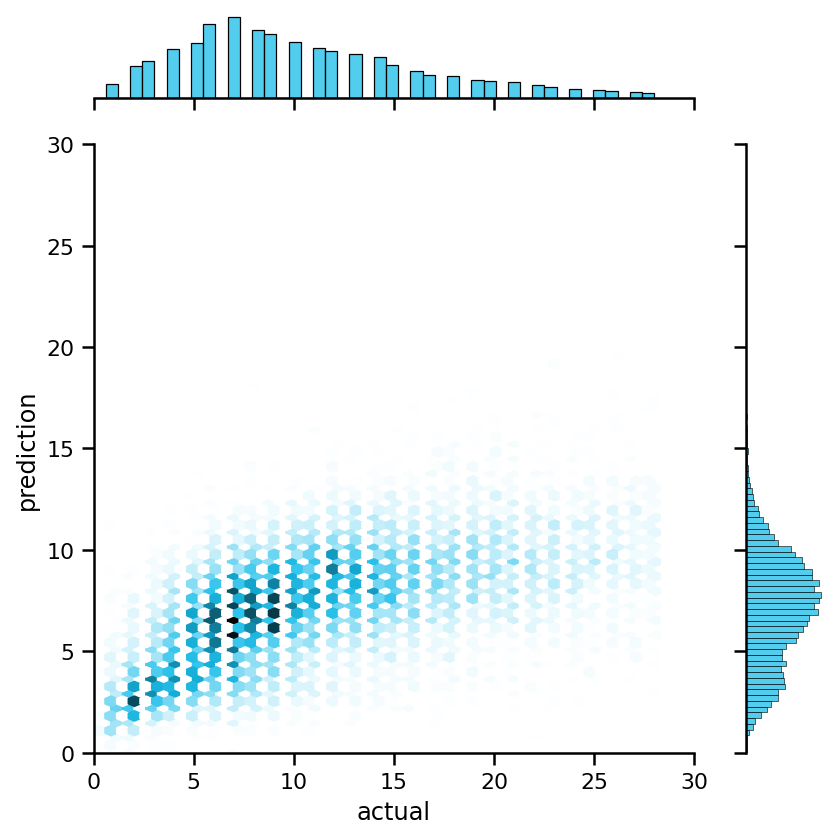

In [113]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

g = sns.jointplot('actual', 'prediction', data=score_df,
                  kind='hex', color=custom_color, space=0,
                  xlim=(0,30), ylim=(0,30))
plt.tight_layout()
plt.show()

So, our effort for creating custom loss function is not as good as we though. While that using asymetric mse is one of a good approach, currently our model with Poisson objective and RMSE evaluation metric is better than the custom one.

Also, we can see that average diff is too much to be used for end user, so this model can be used as performance indicator for shipping team, thus using RMSE as its loss func might be better because we don't need to focus on not late problem anymore

## $Hyperparameter\ Tuning$
---
Using **hyperopt** for hyperparameter tuning

**Hyperparameter** to tune (range):
- learning rate : 0.05, 0.1
- depth : 3, 5, 7
- l2_leaf_reg : 1, 3, 5, 7

In [114]:
import hyperopt

def hyperopt_objective(params):
    
    param = {
        'objective' : 'Poisson',
        'loss_function' : 'RMSE',
        'eval_metric' : 'RMSE', 
        # 'task_type' : 'GPU',
        'learning_rate' : params['learning_rate'],
        'depth':int(params['depth']),
        'l2_leaf_reg':params['l2_leaf_reg'],
        'use_best_model': True,
        'verbose': False,
        'iterations' : 10000, 
        'early_stopping_rounds' : 100,
        'cat_features' :cat_num_features + cat_str_features
    }
    
    tuned_model = CatBoostRegressor(**param)
    tuned_model.fit(
        X_train, 
        y_train, 
        eval_set = (X_test, y_test), 
        use_best_model = True
    )
        
    pred = tuned_model.predict(X_test)
    pred = np.where(pred < 0, 0, pred)
    rmsle, rmse, r2 = evaluate_model(y_test, pred)
    
    return rmsle # as hyperopt minimises

In [115]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 3, 8, 2),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.quniform('depth', 3, 7, 2),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

RMSLE:
0.18390509574385946
RMSE:
4.723627236929092
R2:
0.38770799122304145
__________________________________
RMSLE:
0.18278080799420623
RMSE:
4.730307827422388
R2:
0.3859748465316156
__________________________________
RMSLE:
0.18584622141084017
RMSE:
4.760908837598215
R2:
0.3780047238581853
__________________________________
RMSLE:
0.18274447064720192
RMSE:
4.716939104987582
R2:
0.38944063880079205
__________________________________
RMSLE:
0.1830147944722008
RMSE:
4.719059283313404
R2:
0.38889164479372984
__________________________________
RMSLE:
0.18301621171840798
RMSE:
4.705461144055817
R2:
0.39240843207133713
__________________________________
RMSLE:
0.18066386756364777
RMSE:
4.694108699935854
R2:
0.3953366588452001
__________________________________
RMSLE:
0.1828819148490538
RMSE:
4.728613051872744
R2:
0.3864147538000252
__________________________________
RMSLE:
0.18299036376654404
RMSE:
4.7185699498633475
R2:
0.38901837354956914
__________________________________
RMSLE:
0.183273

In [118]:
tuned_param = {
    'l2_leaf_reg' : int(best['l2_leaf_reg']),
    'learning_rate' : best['learning_rate'],
    'depth' : int(best['depth']),
    'objective' : 'Poisson',
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE', 
    # 'task_type' : 'GPU',
    'use_best_model': True,
    'verbose': 100,
    'iterations' : 10000,
    'early_stopping_rounds' : 100,
    'cat_features' :cat_num_features + cat_str_features
}

tuned_model = CatBoostRegressor(**tuned_param)
tuned_model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test), 
    use_best_model = True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 11.8951274	test: 11.9762766	best: 11.9762766 (0)	total: 139ms	remaining: 23m 9s
100:	learn: 10.0652399	test: 10.1416342	best: 10.1416342 (100)	total: 13.4s	remaining: 21m 55s
200:	learn: 10.0574323	test: 10.1352990	best: 10.1352990 (200)	total: 27.2s	remaining: 22m 7s
300:	learn: 10.0537464	test: 10.1328985	best: 10.1328903 (299)	total: 40.8s	remaining: 21m 53s
400:	learn: 10.0509495	test: 10.1314555	best: 10.1314555 (400)	total: 54.3s	remaining: 21m 39s
500:	learn: 10.0487813	test: 10.1302499	best: 10.1302479 (499)	total: 1m 7s	remaining: 21m 25s
600:	learn: 10.0468487	test: 10.1295596	best: 10.1295596 (600)	total: 1m 21s	remaining: 21m 10s
700:	learn: 10.0453012	test: 10.1292879	best: 10.1292855 (699)	total: 1m 34s	remaining: 20m 54s
800:	learn: 10.0436751	test: 10.1288717	best: 10.1288673 (796)	total: 1m 48s	remaining: 20m 40s
900:	learn: 10.0420788	test: 10.1284537	best: 10.1284537 (900)	total: 2m 1s	remaining: 20m 29s
1000:	learn: 10.0406011	test: 10.1280796	best: 10.128

In [119]:
# === Plot result ===
pred = tuned_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

RMSLE: 0.1785005564820028
RMSE: 4.664646464314179
R2: 0.40290309094822185
__________________________________


[]

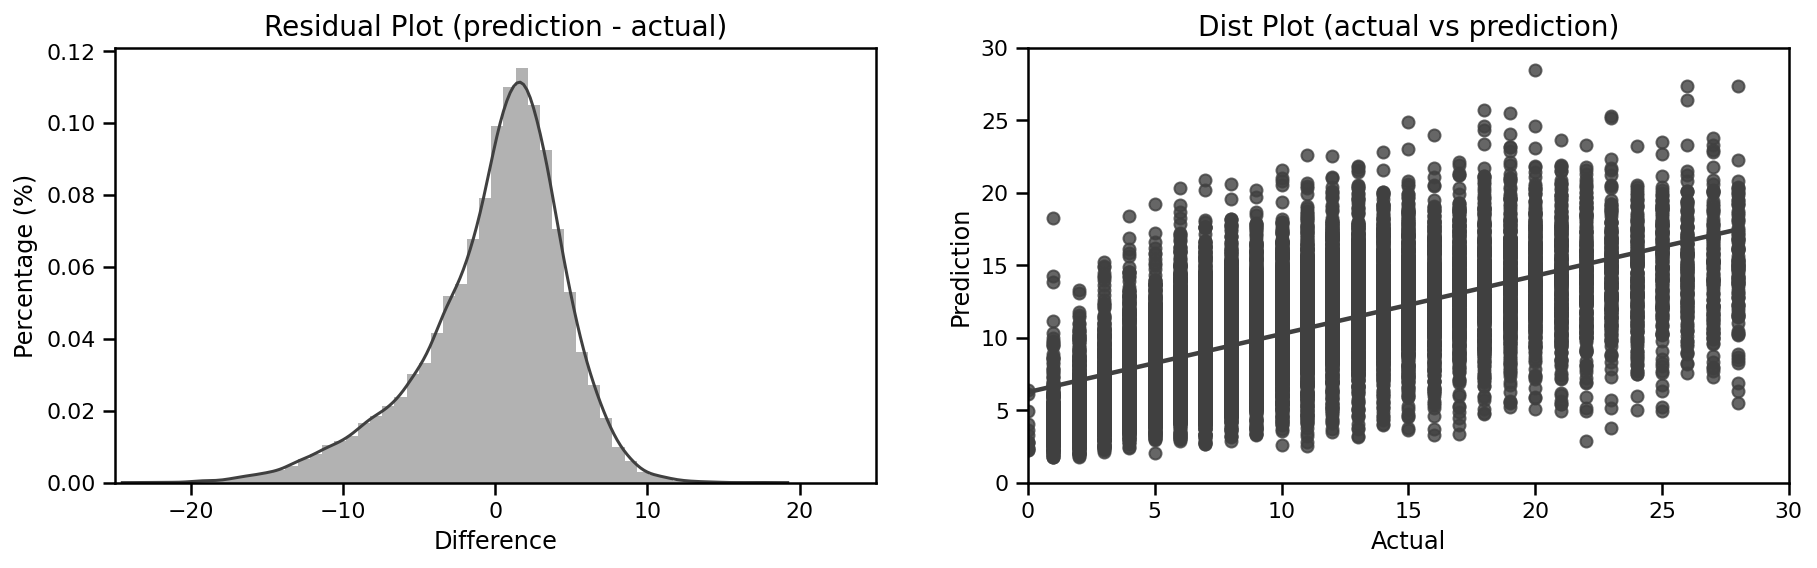

In [120]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(15,4))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color="0.25")
a.set_xlabel("Difference",fontsize=12)
a.set_ylabel("Percentage (%)",fontsize=12)
a.set_xlim(-25, 25)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color="0.25")
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
g.set_xlim(0,30)
g.set_ylim(0,30)
plt.plot()

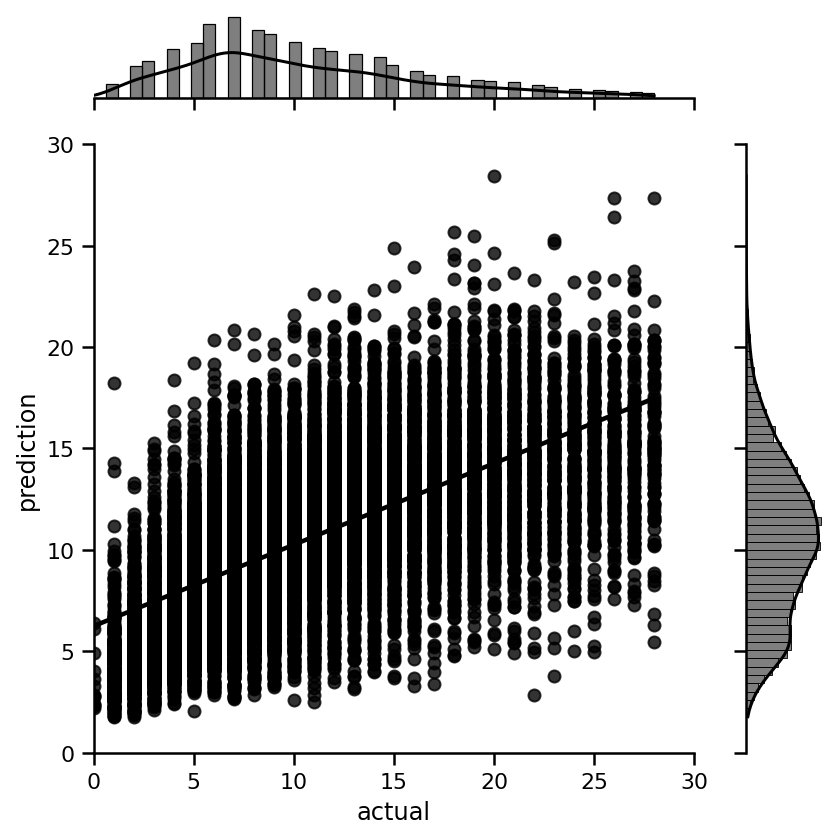

In [121]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

g = sns.jointplot('actual', 'prediction', data=score_df,
                  kind='reg', color=tuned_color, space=0,
                  xlim=(0,30), ylim=(0,30),)
plt.tight_layout()
plt.show()

In [122]:
# == Save Model ==
save_model(tuned_model, 'catboost-regressor-tuned')

In [128]:
# == Load all model ==
rmsle_score = []; rmse_score=[]; r2_score = []
baseline_model = load_model(f'{dir}/bin/catboost-regressor')
custom_model = load_model(f'{dir}/bin/catboost-regressor-custom')
tuned_model = load_model(f'{dir}/bin/catboost-regressor-tuned')

print("===Baseline===")
pred = baseline_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

print("===Custom Loss===")
pred = custom_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

print("===Tuned===")
pred = tuned_model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

rmsle_score.append(rmsle)
rmse_score.append(rmse)
r2_score.append(r2)

===Baseline===
RMSLE: 0.17876376434236232
RMSE: 4.664363989171438
R2: 0.40297540507921314
__________________________________
===Custom Loss===
RMSLE: 0.2577473482941465
RMSE: 6.023162075241747
R2: 0.004465180603994479
__________________________________
===Tuned===
RMSLE: 0.1785005564820028
RMSE: 4.664646464314179
R2: 0.40290309094822185
__________________________________


In [129]:
# === versus (all model type) ===
results_df = pd.DataFrame(data=[["Baseline", rmsle_score[0], rmse_score[0], r2_score[0]], 
                                ['Custom', rmsle_score[1], rmse_score[1], r2_score[1]], 
                                ['Tuned', rmsle_score[2], rmse_score[2], r2_score[2]]], 
                          columns=['Model', 'RMSLE', 'RMSE', "R2"])
results_df.style.highlight_min(subset=['RMSLE', 'RMSE'],color='lightgreen', axis = 0).highlight_max(subset=['R2'], color = 'lightgreen', axis = 0)

,Model,RMSLE,RMSE,R2
0,Baseline,0.178764,4.664364,0.402975
1,Custom,0.257747,6.023162,0.004465
2,Tuned,0.178501,4.664646,0.402903


**Cross Validation**

ps: Because training took too long, only using tuned model to train the result

In [130]:
# === Create a cross validation scoring ===
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores_rmse = []
scores_rmsle = []
scores_r2 = []
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"=== Fold {idx+1} ===")
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    pred_fold = tuned_model.predict(X_test_fold)
    pred_fold = np.where(pred_fold < 0, 0, pred_fold)
    rmsle, rmse, r2  = evaluate_model(y_test_fold,pred_fold)
    
    scores_rmse.append(rmse)
    scores_rmsle.append(rmsle)
    scores_r2.append(r2)
print("Precise RMSLE score :", np.min(scores_rmsle))
print("Precise RMSE score :", np.min(scores_rmse))

=== Fold 1 ===
RMSLE: 0.1785005564820028
RMSE: 4.664646464314179
R2: 0.40290309094822196
__________________________________
=== Fold 2 ===
RMSLE: 0.15161282405013177
RMSE: 4.119091670126302
R2: 0.5353184409099557
__________________________________
=== Fold 3 ===
RMSLE: 0.14976373984060262
RMSE: 4.155173680922741
R2: 0.528492018137406
__________________________________
=== Fold 4 ===
RMSLE: 0.14846998716631418
RMSE: 4.125469619447926
R2: 0.5354320085147932
__________________________________
=== Fold 5 ===
RMSLE: 0.14932910150522652
RMSE: 4.122277789339521
R2: 0.5339924561718414
__________________________________
Precise RMSLE score : 0.14846998716631418
Precise RMSE score : 4.119091670126302


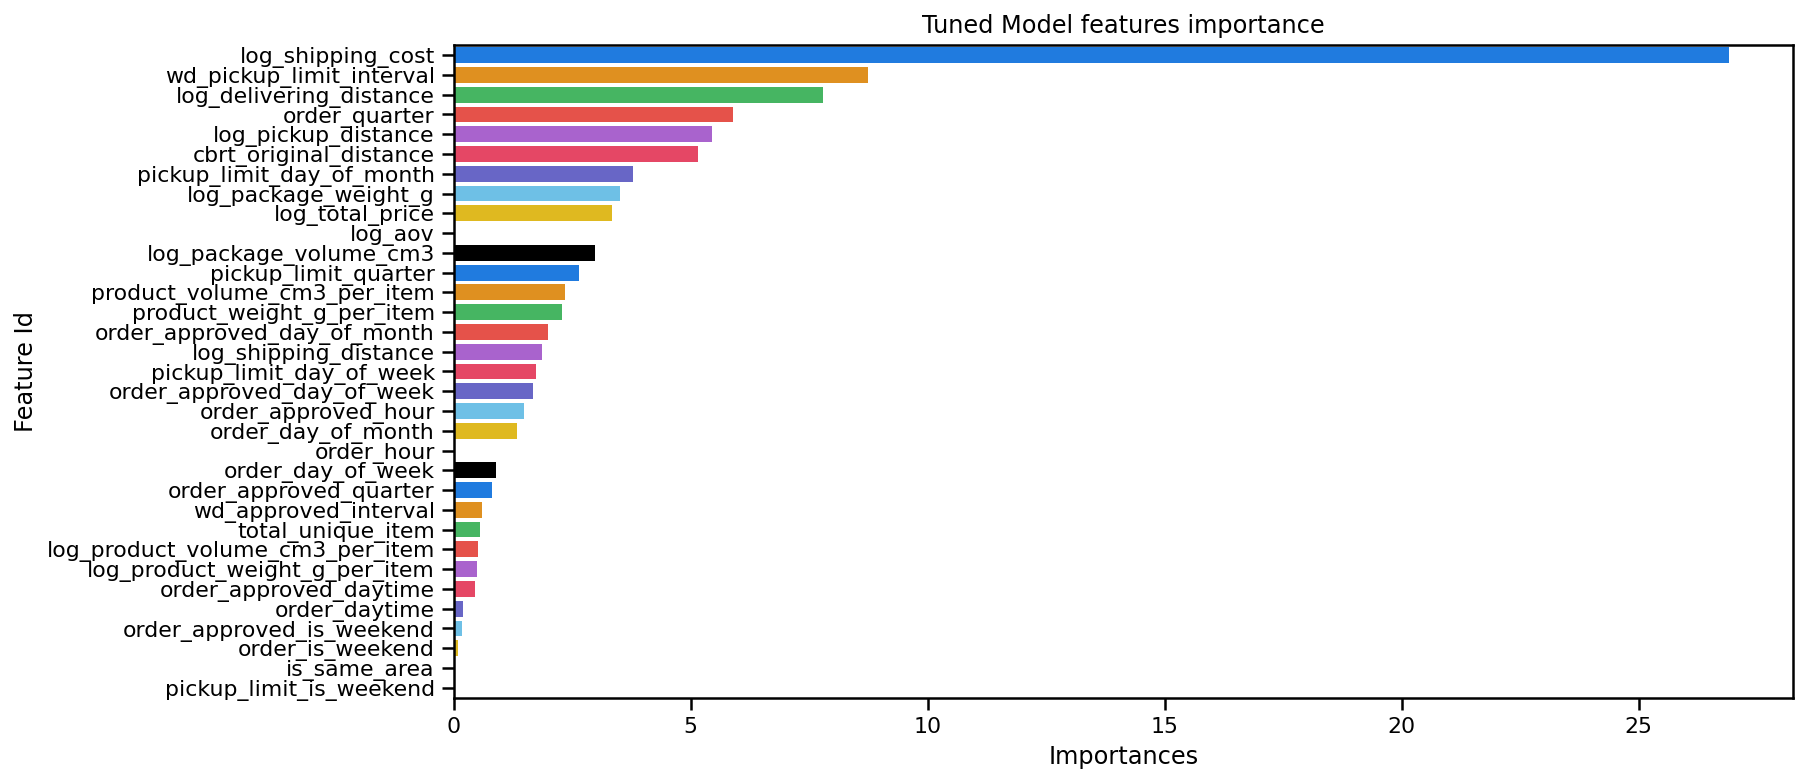

In [131]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=tuned_model.get_feature_importance(prettified=True), palette=light_palette);
plt.title('Tuned Model features importance')
plt.show()

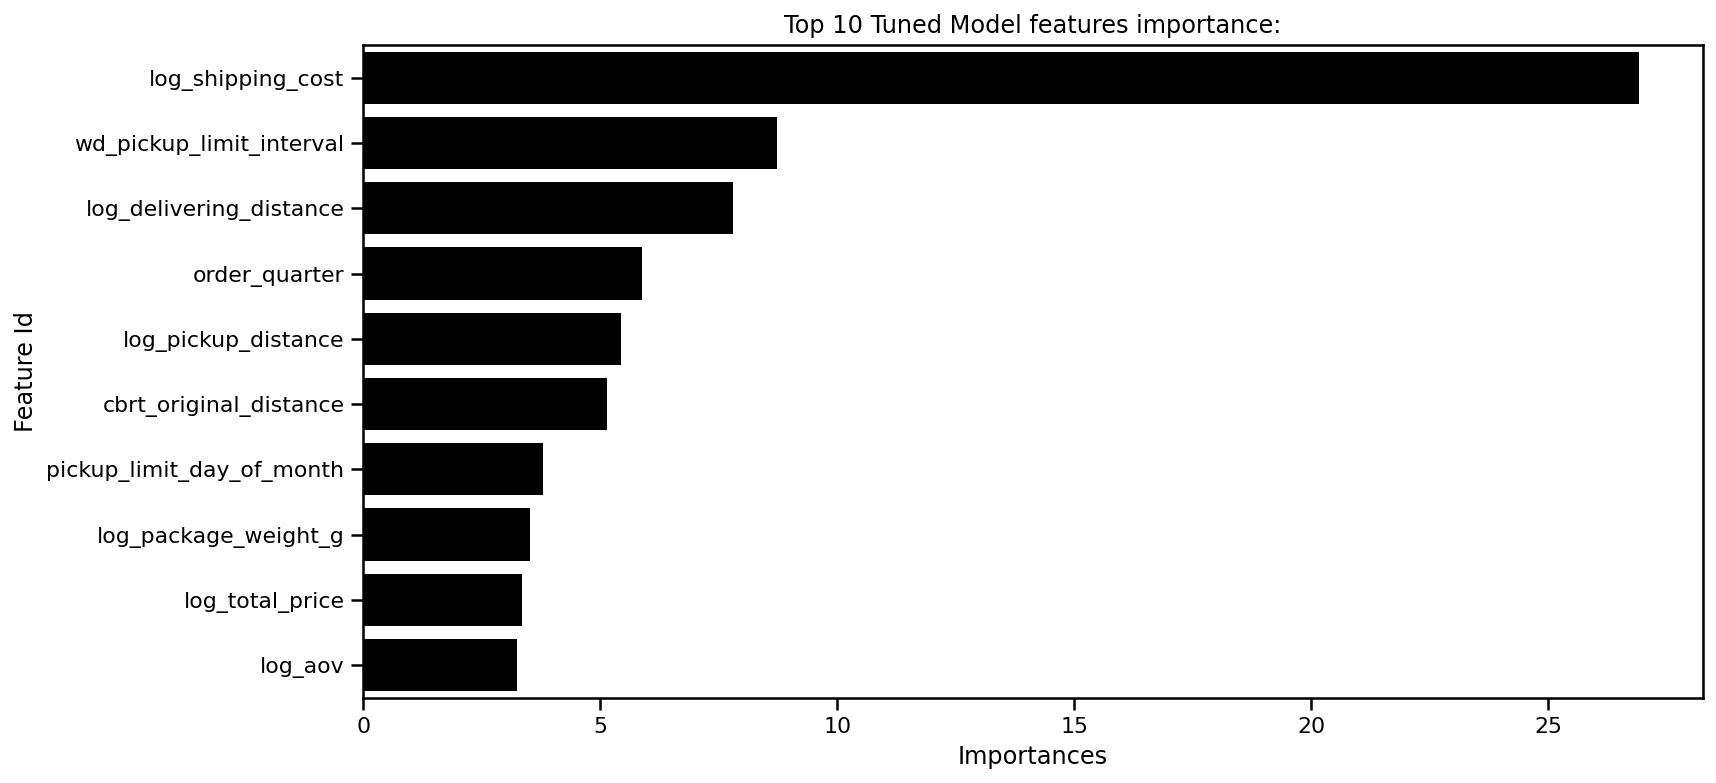

In [132]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=tuned_model.get_feature_importance(prettified=True)[:10], color=light_palette[10]);
plt.title('Top 10 Tuned Model features importance:')
plt.show()

**END**